# Task3
## DeepQLearning Reinforcement Agent with Abstract State Representation
Use involving using the DeepQLearning reinforcement learning algorithm	to train an agent to play Lunar Lander. 

For this task our team made use of Google Colaboratory to benefit from their GPU accelerated hardware for training the agent. We experimented with various different sets of hyper-parameters, resulting in us choosing an annealing epsilon greedy policy to train the agent. This meant that our agent would start its training with a high rate of exploration, changing its approach to be more exploitative the further into the training it gets. The annealing is a popular method as over a large enough range with a low enough rate of cooling (decreasing epsilon), the algorithm becomes more likely to converge to higher maximums.

We found that the training times for this task were extremely long, even using the GPU on Colaboratory, and a lot of steps needed to be taken in order for the agent to improve at the game. As well as this, we found Colaboratory to be quite instable, with training tasks often timing out mid-way through. This led to much frustration in the earlier stages of training the agent as we often lost progress after waiting long periods of time. Because of this we chose to take an iterative approach to training the agent, saving the weights for the model at several stages of progress to evaluate the agent at the different stages of its training. Long training times leave less scope for exploring the effects of different hyperparameters. For deep networks, models can be quite sensitive to small changes in hyperparameters.

    

### Imports

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam, Adamax, SGD, RMSprop

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory



### Extra install steps required for use on Google Colaboratory

Our team ran into difficulty with getting this task running on Colaboratory initially, this was due to an installation error when installing the Box2D component of the gym library. Locally, this was done using an Anaconda package but downloading and setting up an Anaconda environment on Colaboratory proved troublesome so the following sequence of commands were used to solve this issue. They are listed in comments below. 

In [9]:
## SOLUTION TO INSTALL BOX2D/GYM WITHOUT CONDA ON COLABORATORY

# !apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
# !git clone https://github.com/openai/gym.git
# cd gym
# !pip install -e .
# !pip install -e '.[box2d]'

### Set up Lunar Lander environment


In [10]:
ENV_NAME = 'LunarLander-v2'
WINDOW_LENGTH = 1 # we only look ahead by 1 state.
record_video_every = 100

# setting up Lunar Lander environment and the corresponding gameplay actions
env = gym.make(ENV_NAME)
nb_actions = env.action_space.n


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Build model

In [13]:
#build a model
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(32, kernel_initializer='lecun_uniform', activation='relu'))
model.add(Dense(32, kernel_initializer='lecun_uniform', activation='relu'))
model.add(Dense(32, kernel_initializer='lecun_uniform', activation='relu'))
model.add(Dense(nb_actions))
model.add(Activation('softmax'))

In [16]:
memory = SequentialMemory(
    limit=1000000,                 #Remember previous 1 million states
    window_length=WINDOW_LENGTH) 

In [17]:
#train first with eploration, then expoitation.
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),#train starting with low esp, to high esp.
                              attr='eps',        #anneal this attr
                              value_max=0.6,       #starting_eps
                              value_min=.001,      #ending_eps
                              value_test=.0001,  #test_mode_
                              nb_steps=2000000)   #take 2 million steps to slowly alter epsilon.

In [18]:
dqn = DQNAgent(model=model, 
               nb_actions=nb_actions, 
               memory=memory, 
               nb_steps_warmup=1000,     #Run this many before anealing (learn to fall)
               target_model_update=1000, #update model/adjust weights? every 1000 steps?
               policy=policy)

dqn.compile(Adam(lr=.1e-3), metrics=['mse'])

### Training the agent

#### This code was run on Google Colaboratory 
#### Do not run locally: requires extensive computation 

In [ ]:
for i in range(0,21):
  
    # fit the dqn algo for 100,000 steps of gameplay
    dqn.fit(env, nb_steps=100000,verbose=0)

    # save the weights
    dqn.save_weights("TESTpoint6eps2mil_weights_"+str(i*100000)+"_.h5f", overwrite=True)

    # printing progress
    print("Completed Steps: "+str(i*100000)+"/2000000")

    # running one test to see how effective it seems
    dqn.test(env, nb_episodes=1, visualize=False)

    try: # handling errors in file download from Colaboratory, files can be downloaded to local computer at a later time
    # download to local for testing
    files.download("TESTpoint6eps2mil_weights_"+str(i*100000)+"_.h5f")
    except:
    pass

From the above we generated a lot of files containing the weights used by the model. From this we picked one which seemed to be the best at playing the game, this occurred after 1.2 million gameplay steps when using an epsilon value changing from 0.6 to 0.001 over 2 million steps. 

In [19]:
# used to save the model
dqn.model.save('rl_model.mod')

### Evaluating results

The lunar_lander_rl_player script.py was adapted to run an agent as above with the weights which were saved from each 100k increment of gameplay steps. This resulted in 200 episodes of gameplay being recorded for each of these increments. Our team found it more difficult to get good, well-scoring results using reinforcement learning so the majority of the episodes below still achieve a negative score. The results of our evaluation have been loaded into a dataframe below and analysed.

In [21]:
# read in data frame
rl_results = pd.read_csv('RL_results.csv')

In [24]:
# take a peek at some of the results
rl_results.head()

,100k,200k,300k,400k,500k,600k,700k,800k,900k,1mil,1.1mil,1.2mil
0,-521.402,-474.417,-478.680,-277.716,-322.181,-108.429,-124.642,-750.716,-144.496,-650.839,-513.201,-268.795
1,-512.016,-594.834,-523.862,-269.644,-175.001,-216.392,-311.952,-390.556,-260.091,-865.583,-605.925,-114.814
2,-93.986,-480.924,-489.190,168.461,-210.357,-587.219,-432.920,-815.526,-126.185,-767.665,-540.271,-311.657
3,-428.821,-518.917,-487.168,-143.930,191.104,177.437,-320.715,-736.037,-169.031,-780.381,-742.309,-192.621
4,-458.162,-459.806,-435.948,-233.445,144.641,-388.518,-419.464,-210.565,-338.366,-551.847,-572.521,99.420


In [26]:
# look at some statistics relating to the results
rl_results.describe()

,100k,200k,300k,400k,500k,600k,700k,800k,900k,1mil,1.1mil,1.2mil
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000
mean,-309.651260,-479.926255,-469.008560,-408.652365,-204.214420,-384.271425,-246.024585,-545.75241,-158.788860,-728.889990,-584.118520,-144.185890
std,144.246774,88.348769,67.175811,298.568284,125.813407,217.267393,125.142272,182.69556,120.814434,156.066646,271.524104,120.997379
min,-521.402000,-645.952000,-618.574000,-1070.014000,-426.299000,-754.046000,-494.729000,-927.84900,-385.068000,-1347.148000,-1022.975000,-379.897000
25%,-438.933250,-525.274000,-506.175500,-600.626250,-287.105250,-575.343250,-330.960500,-682.97700,-255.043750,-817.714750,-797.751750,-240.378500
50%,-333.999000,-482.414000,-464.362000,-298.162500,-211.994500,-453.944000,-264.217000,-547.00100,-162.785000,-752.009500,-592.052500,-138.678500
75%,-200.965000,-446.296000,-433.655000,-207.853250,-153.344000,-208.164500,-159.175000,-434.79625,-77.801250,-618.225250,-481.218250,-74.779750
max,116.103000,-16.665000,-149.025000,195.451000,237.587000,192.505000,185.135000,-18.42300,209.176000,-351.390000,252.591000,234.056000


#### Visualising results using charts

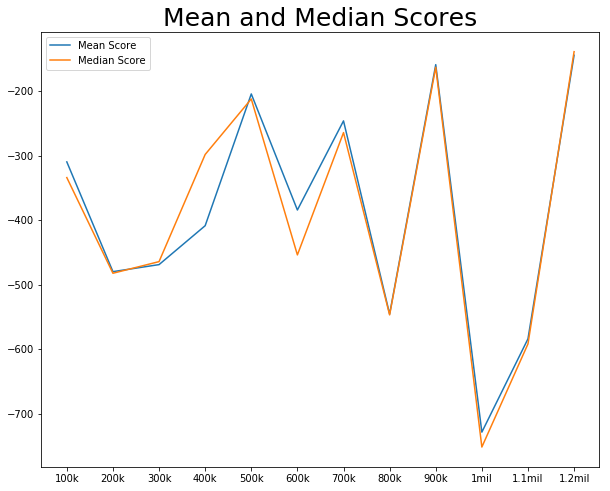

In [103]:
mean_median_plot = pd.DataFrame({
        'Mean Score':rl_results.mean(), 
        'Median Score': rl_results.median()
        }
        ).plot(title="Mean and Median Scores", figsize=(10,8), legend=True, xticks=(list(range(12))))
mean_median_plot.title.set_size(25)

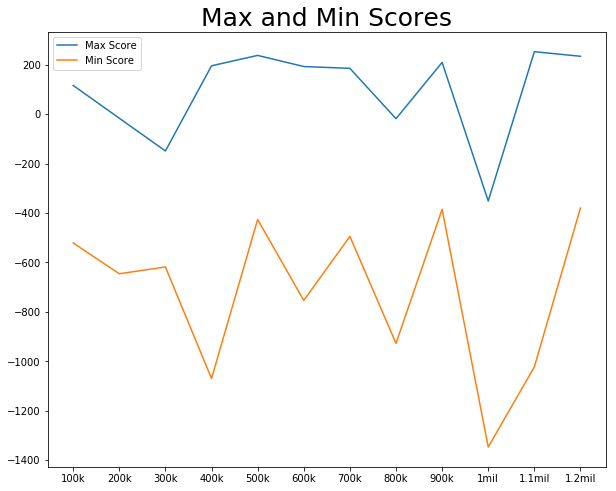

In [100]:
max_min_plot=pd.DataFrame({ 
    'Max Score':rl_results.max(),
    'Min Score':rl_results.min()
            }).plot(title = "Max and Min Scores", kind ='line', 
                    figsize=(10,8), legend=True, xticks=(list(range(12))))
max_min_plot.title.set_size(25)

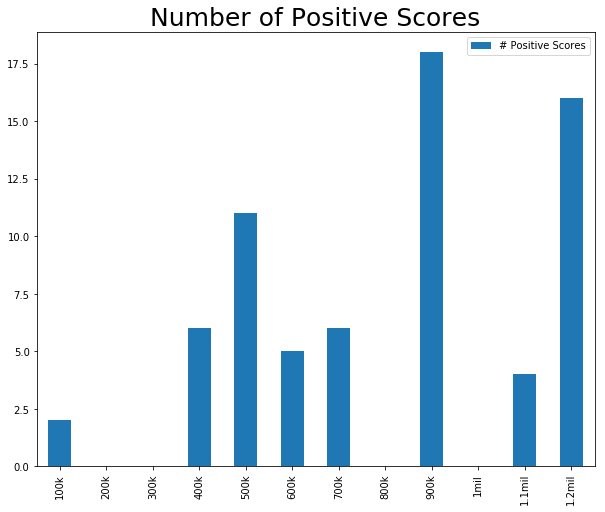

In [99]:
positive_scores_plot = pd.DataFrame(
    {'# Positive Scores':rl_results[rl_results>0].count()
    }).plot(title='Number of Positive Scores',
            kind ='bar', figsize=(10,8), 
            legend=True, xticks=(list(range(12))))

positive_scores_plot.title.set_size(25)

### Analysis

As we can see from the graphs above, the scores achieved for each of number of steps is quite volatile and no clear pattern can be obtained. From this information and from visualising the agent playing the game, the areas where the graph is rising corresponds to times when the agent is learning a certain strategy. Some strategies that seemed apparent to us involved rocking from side to side, swinging into a landing to avoid crashing and simply avoiding landing as much as possible. 

Given the high choice of epsilon (0.6 to start) for this exericse, it's likely that the agent was exploring away from these strategies as the training continued. These results aren't exactly what we were expecting as we were hoping to see a steady increase in the score as the number of steps increases, this was the case for several different choices of hyper-parameters (choice of nb_steps and max epsilon value in particular).

It's hard to know if the low scores achieved here are a result of poor parameters or simply not enough data. If we look at the bar chart showing the number of positive scores achieved there does seem to be an upward trend as the number of steps increase, suggesting that the problems the agent is encountering now may start to become less of an issue with an even bigger number of steps. Unfortunately, even with Google Colaboratory's GPU, we didn't have the computation power to test this fully.

